这堂课我们将学习如何使用Python进行面向对象式编程（Object-Oriented Programming，简称OOP）。我们将通过实现一个简单的量化交易策略，来深入理解OOP这种编程范式的强大之处。通过这堂课，你将掌握如下知识点。

1. 使用Python进行OOP的基本语法。包括类（class）、实例（instance）、属性（attribute）以及方法（method）等知识点。
2. 如何从OOP的角度进行思考，设计复杂问题的解决方案。
3. 使用Python进行OOP的高级语法。包括`__repr__`、`__call__`等特殊方法的使用，以及`@property`装饰器的使用等进阶知识点。

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# 问题描述

我们将实现一个简单的基于趋势跟随（Trend Following）的股票交易策略（Trading Strategy）。该策略通过判断一只股票的当前价格是否高于（低于）其近期的均值水平，来决定是否买入（卖出）该股票。我们将基于该策略，构造一个投资组合（Portfolio），并通过回测（backtest）该Portfolio的历史表现，来评估策略的有效性。

思考：如何拆解该问题？

1. Portfolio是由股票构成的资产集合。那么，如何存储单支股票的数据？
2. 基于个股数据，便可以进行模拟交易。所谓构建Portfolio，本质上是追踪一系列股票交易行为。那么，如何存储交易数据？
3. 基于一个Portfolio的交易数据，可以计算该Portfolio在任意时间点的持仓数据。结合个股数据，便可以计算该Portfolio在该时间点的资产价值。
4. 交易策略，可以抽象地理解为一个根据给定规则生成交易数据的算法。那么，该如何设计这个算法？

接下来，让我们先关注第一个问题，并学习如何基于OOP的思想来设计解决方案。

不过在正式开始OOP的学习之前，让我们先来准备些股票的历史数据。

In [2]:
# Fetch real-world stock data
stock_symbols = ["AAPL", "MSFT", "GOOGL", "BA", "WBA", "INTC"]
start_date = "2020-01-01"
end_date = "2024-10-31"

save_path = Path('./stock_data')
save_path.mkdir(exist_ok=True)
resave = False

stock_data = {}
for symbol in stock_symbols:
    save_as = save_path/f"{symbol}.csv"
    if not save_as.is_file() or resave:
        try:
            import yfinance as yf
            stock_df = yf.download(symbol, start=start_date, end=end_date)
            stock_df = stock_df.droplevel(level='Ticker', axis=1)
            stock_df.columns.name = None
            stock_df.index.name = None
            stock_df.index = stock_df.index.tz_localize(None)
            stock_df.to_csv(save_as, index=True)
        except ImportError:
            # Install the required library
            # !pip install yfinance
            raise ImportError('The yfinance has not been imported!')
    else:
        stock_df = pd.read_csv(save_as, index_col=0, parse_dates=True)
    stock_data[symbol] = dict(zip(stock_df.index.to_pydatetime(), stock_df["Adj Close"]))

In [8]:
# stock_data['AAPL']

In [9]:
stock_df["Adj Close"]

2020-01-02    53.666470
2020-01-03    53.013714
2020-01-06    52.863766
2020-01-07    51.981674
2020-01-08    52.016960
                ...    
2024-10-24    22.340000
2024-10-25    22.680000
2024-10-28    22.920000
2024-10-29    22.900000
2024-10-30    22.299999
Name: Adj Close, Length: 1216, dtype: float64

In [10]:
for k, v in stock_data['AAPL'].items():
    print(k, v, type(k), type(v), sep=' | ')
    break

2020-01-02 00:00:00 | 72.87610626220703 | <class 'datetime.datetime'> | <class 'float'>


In [11]:
1.0+2.0

3.0

$\Delta$

In [22]:
datetime(2023, 12, 1, 0, 0) - timedelta(days=2)

datetime.datetime(2023, 11, 29, 0, 0)

In [24]:
# stock_data['AAPL']

如何方便的查看字典的前n个条目（entry）？

In [25]:
for i, (k, v) in enumerate(stock_data['AAPL'].items()):
    print(k, v, type(k), type(v), sep=' | ')
    if i >= 5:
        break

2020-01-02 00:00:00 | 72.87610626220703 | <class 'datetime.datetime'> | <class 'float'>
2020-01-03 00:00:00 | 72.16758728027344 | <class 'datetime.datetime'> | <class 'float'>
2020-01-06 00:00:00 | 72.74266052246094 | <class 'datetime.datetime'> | <class 'float'>
2020-01-07 00:00:00 | 72.40054321289062 | <class 'datetime.datetime'> | <class 'float'>
2020-01-08 00:00:00 | 73.5652084350586 | <class 'datetime.datetime'> | <class 'float'>
2020-01-09 00:00:00 | 75.12776947021484 | <class 'datetime.datetime'> | <class 'float'>


我们将每支股票的数据，存储为一个字典。该字典的每个条目中，键（key）是一个时间日期，表示一个交易日；值（value）是该股票在该交易日的收盘价格，可以用来近似交易策略中可以执行的买卖价格。

In [5]:
k

datetime.datetime(2020, 1, 9, 0, 0)

注意到，每个key的类型为`datetime.datetime`。用OOP的术语来说，每个key是`datetime.datetime`类的一个实例（instance）。通过这个例子，你可以总结出类和实例的一般定义么？

注意，在OOP的相关资料中，会频繁使用对象（object）这一术语。大部分情况下，可以将object理解为instance的同义词。

# 定义`Stock`类

考虑到不同的股票都有相同的数据字段，我们可以定义`Stock`类，来一般性地描述一支股票应该包含的数据以及支持的操作。下面的代码声明了`Stock`类，请阅读该代码来理解以下知识点。

1. 如何声明一个类？
2. 如何定义一个类的实例化方法，即`__init__`方法？
3. 什么是以及如何定义实例属性（attribute）和实例方法（method）？
4. 如何理解实例方法中的`self`参数？

In [76]:
# Define the Stock class
class Stock:
    
    def __init__(self, name, ticker, historical_prices):
        # ticker might change over time, `name` is intended to hold the permenant name of a stock
        self.name = name
        self.ticker = ticker
        self.historical_prices = historical_prices  # Dictionary of {date: price}
        self.trading_dates = sorted(historical_prices.keys())  # Only store valid trading dates
    
    def get_price(self, date):
        return self.historical_prices.get(date, None)
    
    def __getitem__(self, idx):
        return self.get_price(self.trading_dates[idx])

In [77]:
symbol = 'AAPL'
stock_aapl = Stock(symbol, symbol, stock_data[symbol])

In [75]:
stock_aapl.trading_dates[1]

datetime.datetime(2020, 1, 3, 0, 0)

In [79]:
stock_aapl[1]

72.16758728027344

In [47]:
stock_aapl.get_price(datetime(2020, 1, 22, 0, 0))

77.08585357666016

In [43]:
stock_aapl.historical_prices.get(datetime(2020, 1, 22, 0, 0), None)

77.08585357666016

In [49]:
stock_aapl

In [9]:
# stock_aapl.trading_dates

In [10]:
stock_aapl.historical_prices[stock_aapl.trading_dates[0]]

72.87610626220703

按照如下方案进一步完善`Stock`类。


1. 定义实例方法`__getitem__`，让查询股票历史价格变得更加方便。
2. 定义实例方法`__repr__`，更直观地展示`Stock`对象的内容。
3. 定义实例方法`get_trading_dates_in_range`，返回一个给定日期范围内的交易日。
4. 定义类属性`stock_data`和类方法`from_ticker`，让根据股票ticker实例化`Stock`对象更加方便。

请阅读下方代码，学习并掌握上述4个知识点。


In [99]:
# Define the Stock class
class Stock:
    
    # make `stock_data` a private attribute
    _stock_data = stock_data
    # alternatively, make `stock_data` a public attribute
#     _stock_data = stock_data
    
    def __init__(self, name, ticker, historical_prices):
        # ticker might change over time, `name` is intended to hold the permenant name of a stock
        self.name = name
        self.ticker = ticker
        self.historical_prices = historical_prices  # Dictionary of {date: price}
        self.trading_dates = sorted(historical_prices.keys())  # Only store valid trading dates
    
    
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.historical_prices[self.trading_dates[idx]]
        elif isinstance(idx, datetime):
            return self.get_price(idx)
        else:
            raise NotImplementedError
            
    def __repr__(self):
        k0 = self.trading_dates[0]
        v0 = self.historical_prices[k0]
        k0_str = k0.strftime('%Y-%m-%d')
        k1 = self.trading_dates[-1]
        v1 = self.historical_prices[k1]
        k1_str = k1.strftime('%Y-%m-%d')
        return f"name:{self.name}|ticker:{self.ticker}|data:{{{k0_str}:{v0:.2f}, ..., {k1_str}:{v1:.2f}}}"
            
    def get_price(self, date):
        return self.historical_prices.get(date, None)

    def get_trading_dates_in_range(self, start_date, end_date):
        # Filter trading dates within the specified date range
        return [date for date in self.trading_dates if start_date <= date <= end_date]
    
    @classmethod
    def from_ticker(cls, symbol):
        return cls(symbol, symbol, cls._stock_data[symbol])

In [100]:
for date in stock_aapl.trading_dates:
    print(date)
    break

2020-01-02 00:00:00


测试功能

In [104]:
symbol = 'AAPL'
stock_aapl = Stock(symbol, symbol, stock_data[symbol])
Stock(symbol, symbol, Stock._stock_data[symbol])

name:AAPL|ticker:AAPL|data:{2020-01-02:72.88, ..., 2024-10-30:230.10}

In [105]:
stock_aapl[0]

72.87610626220703

In [106]:
stock_aapl[stock_aapl.trading_dates[0]]

72.87610626220703

In [107]:
stock_aapl

name:AAPL|ticker:AAPL|data:{2020-01-02:72.88, ..., 2024-10-30:230.10}

In [108]:
k0 = stock_aapl.trading_dates[0]
v0 = stock_aapl.historical_prices[k0]
# k0_str = k0.strftime('%Y-%m-%d')

In [109]:
k0.strftime('%Y%m%d')

'20200102'

In [110]:
stock_aapl.get_trading_dates_in_range(stock_aapl.trading_dates[-3], stock_aapl.trading_dates[-1])

[datetime.datetime(2024, 10, 28, 0, 0),
 datetime.datetime(2024, 10, 29, 0, 0),
 datetime.datetime(2024, 10, 30, 0, 0)]

In [111]:
Stock('AAPL', 'AAPL', stock_data['AAPL'])
Stock('MSFT', 'MSFT', stock_data['MSFT'])

name:MSFT|ticker:MSFT|data:{2020-01-02:153.94, ..., 2024-10-30:432.53}

In [112]:
stock_aapl = Stock.from_ticker('AAPL')

Stock('AAPL', 'AAPL', Stock._stock_data['AAPL'])

stock_aapl

name:AAPL|ticker:AAPL|data:{2020-01-02:72.88, ..., 2024-10-30:230.10}

In [97]:
Stock._stock_data

{'AAPL': {datetime.datetime(2020, 1, 2, 0, 0): 72.87610626220703,
  datetime.datetime(2020, 1, 3, 0, 0): 72.16758728027344,
  datetime.datetime(2020, 1, 6, 0, 0): 72.74266052246094,
  datetime.datetime(2020, 1, 7, 0, 0): 72.40054321289062,
  datetime.datetime(2020, 1, 8, 0, 0): 73.5652084350586,
  datetime.datetime(2020, 1, 9, 0, 0): 75.12776947021484,
  datetime.datetime(2020, 1, 10, 0, 0): 75.2976303100586,
  datetime.datetime(2020, 1, 13, 0, 0): 76.90630340576172,
  datetime.datetime(2020, 1, 14, 0, 0): 75.8678207397461,
  datetime.datetime(2020, 1, 15, 0, 0): 75.54267883300781,
  datetime.datetime(2020, 1, 16, 0, 0): 76.48898315429688,
  datetime.datetime(2020, 1, 17, 0, 0): 77.3357925415039,
  datetime.datetime(2020, 1, 21, 0, 0): 76.81167602539062,
  datetime.datetime(2020, 1, 22, 0, 0): 77.08585357666016,
  datetime.datetime(2020, 1, 23, 0, 0): 77.45709228515625,
  datetime.datetime(2020, 1, 24, 0, 0): 77.23385620117188,
  datetime.datetime(2020, 1, 27, 0, 0): 74.96278381347656,

# 定义`Portfolio`类

回忆我们之前的分析：

    ...
    2. 基于个股数据，便可以进行模拟交易。所谓构建Portfolio，本质上是追踪一系列股票交易行为。那么，如何存储交易数据？
    3. 基于一个Portfolio的交易数据，可以计算该Portfolio在任意时间点的持仓数据。结合个股数据，便可以计算该Portfolio在该时间点的资产价值。
    ...
    
思考：如何基于OOP的思想，实现上述需求？

请利用你从`Stock`类的实现中学到的知识，设计`Portfolio`类。具体而言，需实现如下功能。

1. 属性：
    + 现金（`cash`）
    + 持仓信息（`holdings`）
    + 交易历史（`trade_history`）

2. 方法：
    + 转入现金（`deposit_cash`）
    + 买单支股票（`buy_stock`）
    + 卖单支股票（`sell_stock`）
    + 基于当前持仓，估计任意时间点**当前**持有资产的总价值（`get_value_c`）
    + 回溯交易历史，估计任意时间点**历史**持有资产的总价值（`get_value_h`）
    
思考：`holdings`和`trade_history`该用什么数据结构存储？实现`buy_stock`和`sell_stock`时该注意哪些事项？实现`get_value_h`时，该如何使用`trade_history`中的信息？

请阅读下方代码，学习并掌握以下几个知识点：

+ `buy_stock`的实现逻辑
+ `holding_stocks`的实现方法及意义
+ `get_averge_holding_cost`以及`__repr__`的实现细节

In [64]:
# Define the Portfolio class with buy and sell actions
class Portfolio:
    def __init__(self):
        self.cash = 0
        self.holdings = {} 
        self.trade_history = []

    def deposit_cash(self, amount):
        self.cash += amount

    def buy_stock(self, stock, quantity, date):
        price = stock.get_price(date)
        if price is None:
            raise ValueError(f"No price available for {stock.name} on {date}.")
        
        total_cost = price * quantity
        if total_cost >= self.cash:
            raise ValueError("Insufficient funds to buy stock.")
        
        self.cash -= total_cost
        if stock.name in self.holdings:
            self.holdings[stock.name]["quantity"] += quantity
        else:
            self.holdings[stock.name] = {"stock": stock, "quantity": quantity}
        self.trade_history.append(('buy', stock.name, quantity, date, price))
    
    @property
    def holding_stocks(self):
        return list(self.holdings.keys())
    
    def get_averge_holding_cost(self, stock_name, verbose=False):
        purchase_records = [
            # (quantity, price)
            (action[2], action[4]) for action in self.trade_history 
            if (action[0]=='buy') and (action[1]==stock_name)]
        total_value_p = sum([q*p for q, p in purchase_records])
        total_quant_p = sum([q for q, _ in purchase_records])

        sell_records = [
            # (quantity, price)
            (action[2], action[4]) for action in self.trade_history 
            if (action[0]=='sell') and (action[1]==stock_name)]
        total_value_s = sum([q*p for q, p in sell_records])
        total_quant_s = sum([q for q, _ in sell_records])
        
        total_value = total_value_p - total_value_s
        total_quant = total_quant_p - total_quant_s
        average_cost = total_value/total_quant
        
        if verbose:
            return average_cost, total_value, total_quant
        else:
            return average_cost
        
    def __repr__(self):
        cash_info = f"cash: {self.cash:.2f} | "
        stock_info = []
        for stock_name in self.holding_stocks:
            price, value, quant = self.get_averge_holding_cost(stock_name, verbose=True)
            stock_info.append(f"{stock_name}: {value:.2f}={quant}*{price:.2f}")
        stock_info = ' | '.join(stock_info)
        return cash_info + stock_info + " (cost information)"

功能测试

In [66]:
portfolio = Portfolio()
portfolio.deposit_cash(1000)
stock_aapl = Stock.from_ticker('AAPL')
stock_msft = Stock.from_ticker('MSFT')
# portfolio.buy_stock(stock_aapl, 10, datetime.strptime('2023-1-1', '%Y-%m-%d'))
# portfolio.buy_stock(stock_aapl, 20, datetime.strptime('2023-1-5', '%Y-%m-%d'))
portfolio.buy_stock(stock_aapl, 5, stock_aapl.trading_dates[0])
portfolio.buy_stock(stock_msft, 2, stock_aapl.trading_dates[0])
portfolio

cash: 327.74 | AAPL: 364.38=5*72.88 | MSFT: 307.88=2*153.94 (cost information)

In [72]:
portfolio.trade_history

[('buy', 'AAPL', 5, datetime.datetime(2020, 1, 2, 0, 0), 72.87610626220703),
 ('buy', 'MSFT', 2, datetime.datetime(2020, 1, 2, 0, 0), 153.93821716308594)]

进一步完善`Stock`类。

In [69]:
# Define the Portfolio class with buy and sell actions
class Portfolio:
    def __init__(self):
        self.cash = 0
        self.holdings = {} 
        self.trade_history = []

    def deposit_cash(self, amount):
        self.cash += amount

    def buy_stock(self, stock, quantity, date):
        price = stock.get_price(date)
        if price is None:
            raise ValueError(f"No price available for {stock.name} on {date}.")
        
        total_cost = price * quantity
        if total_cost >= self.cash:
            raise ValueError("Insufficient funds to buy stock.")
        
        self.cash -= total_cost
        if stock.name in self.holdings:
            self.holdings[stock.name]["quantity"] += quantity
        else:
            self.holdings[stock.name] = {"stock": stock, "quantity": quantity}
        self.trade_history.append(('buy', stock.name, quantity, date, price))

    def sell_stock(self, stock, quantity, date):
        if stock.ticker not in self.holdings or self.holdings[stock.name]["quantity"] < quantity:
            raise ValueError("Insufficient stock quantity to sell.")
        
        price = stock.get_price(date)
        if price is None:
            raise ValueError(f"No price available for {stock.name} on {date}.")
        
        proceeds = price * quantity
        self.cash += proceeds
        self.holdings[stock.name]["quantity"] -= quantity
        if self.holdings[stock.name]["quantity"] == 0:
            del self.holdings[stock.name]
        self.trade_history.append(('sell', stock.name, quantity, date, price))
    
    def get_value_c(self, date):
        # Calculate total value of the portfolio on a specific date, using the most recent trading date if necessary
        total_value = self.cash
        for holding in self.holdings.values():
            stock = holding["stock"]
            quantity = holding["quantity"]
            
            # Attempt to get the stock price for the requested date
            stock_price = stock.get_price(date)
            
            # If no price available, use the most recent available trading date's price
            if stock_price is None:
                past_trading_dates = [d for d in stock.trading_dates if d <= date]
                if past_trading_dates:
                    most_recent_date = max(past_trading_dates)
                    stock_price = stock.get_price(most_recent_date)
            # Add value to total if a price is found
            if stock_price:
                total_value += stock_price * quantity
                
        return total_value
    
    @property
    def holding_stocks(self):
        return list(self.holdings.keys())
    
    def get_averge_holding_cost(self, stock_name, verbose=False):
        purchase_records = [
            # (quantity, price)
            (action[2], action[4]) for action in self.trade_history 
            if (action[0]=='buy') and (action[1]==stock_name)]
        total_value_p = sum([q*p for q, p in purchase_records])
        total_quant_p = sum([q for q, _ in purchase_records])

        sell_records = [
            # (quantity, price)
            (action[2], action[4]) for action in self.trade_history 
            if (action[0]=='sell') and (action[1]==stock_name)]
        total_value_s = sum([q*p for q, p in sell_records])
        total_quant_s = sum([q for q, _ in sell_records])
        
        total_value = total_value_p - total_value_s
        total_quant = total_quant_p - total_quant_s
        average_cost = total_value/total_quant
        
        if verbose:
            return average_cost, total_value, total_quant
        else:
            return average_cost
        
    def __repr__(self):
        cash_info = f"cash: {self.cash:.2f} | "
        stock_info = []
        for stock_name in self.holding_stocks:
            price, value, quant = self.get_averge_holding_cost(stock_name, verbose=True)
            stock_info.append(f"{stock_name}: {value:.2f}={quant}*{price:.2f}")
        stock_info = ' | '.join(stock_info)
        return cash_info + stock_info + " (cost information)"

功能测试

In [74]:
portfolio = Portfolio()
portfolio.deposit_cash(1000)
stock_aapl = Stock.from_ticker('AAPL')
stock_msft = Stock.from_ticker('MSFT')
portfolio.buy_stock(stock_aapl, 5, stock_aapl.trading_dates[0])
portfolio.buy_stock(stock_msft, 2, stock_aapl.trading_dates[0])
portfolio.sell_stock(stock_aapl, 4, stock_aapl.trading_dates[1])
portfolio.sell_stock(stock_msft, 1, stock_aapl.trading_dates[1])
portfolio.get_value_c(stock_aapl.trading_dates[-1])

1431.0647659301758

In [75]:
portfolio.trade_history

[('buy', 'AAPL', 5, datetime.datetime(2020, 1, 2, 0, 0), 72.87610626220703),
 ('buy', 'MSFT', 2, datetime.datetime(2020, 1, 2, 0, 0), 153.93821716308594),
 ('sell', 'AAPL', 4, datetime.datetime(2020, 1, 3, 0, 0), 72.16758728027344),
 ('sell', 'MSFT', 1, datetime.datetime(2020, 1, 3, 0, 0), 152.02137756347656)]

# 实现交易策略

In [84]:
# Assuming Stock and Portfolio classes are already defined as before
# Only the TSTrendFollow class logic has been updated

class TSTrendFollow:
    def __init__(self, lookback_days=5):
        self.portfolio = Portfolio()
        self.lookback_days = lookback_days

    def __call__(self, stock_pool, investment_amount, start_date, end_date, reset=False):
        if reset:
            self.portfolio = Portfolio()
        # Deposit initial investment
        self.portfolio.deposit_cash(investment_amount)

        # Generate list of all trading dates across the stock pool
        all_dates = sorted(set(date for stock in stock_pool for date in stock.trading_dates))
        trading_dates = [date for date in all_dates if start_date <= date <= end_date]

        for date in trading_dates:
            tradable_stocks = []

            # Check each stock for tradability and trend-following criteria
            for stock in stock_pool:
                # Ensure the stock has a price on the given date
                current_price = stock.get_price(date)
                if current_price is None:
                    continue

                # Calculate moving average for the past lookback_days trading dates
                past_dates = [d for d in stock.trading_dates if d < date][-self.lookback_days:]
                past_prices = [stock.get_price(d) for d in past_dates if stock.get_price(d) is not None]

                # Only consider if we have enough past data
                if len(past_prices) == self.lookback_days:
                    moving_average = np.mean(past_prices)

                    # Determine if the stock satisfies buy/sell condition
                    if current_price > moving_average:
                        tradable_stocks.append((stock, current_price, "buy"))
                    elif current_price < moving_average and stock.ticker in self.portfolio.holdings:
                        tradable_stocks.append((stock, current_price, "sell"))

            # Allocate budget proportionally among stocks that satisfy buy criteria
            if tradable_stocks:
                buy_stocks = [s for s in tradable_stocks if s[2] == "buy"]
                sell_stocks = [s for s in tradable_stocks if s[2] == "sell"]

                # Calculate budget share based on relative performance for buy stocks
                if buy_stocks:
                    total_performance = sum(s[1] for s in buy_stocks)
                    for stock, current_price, _ in buy_stocks:
                        allocation_ratio = current_price / total_performance
                        available_cash = self.portfolio.cash * allocation_ratio
                        quantity = available_cash // current_price
                        if quantity > 0:
                            self.portfolio.buy_stock(stock, quantity, date)

                # Execute sales for stocks that meet the sell condition
                for stock, current_price, _ in sell_stocks:
                    quantity = self.portfolio.holdings[stock.ticker]["quantity"]
                    self.portfolio.sell_stock(stock, quantity, date)

        # Return the final portfolio value at the end date
        return self.portfolio.get_value_c(end_date)

In [85]:
trend_follow_strategy = TSTrendFollow()

Final Portfolio Value: $12654.89


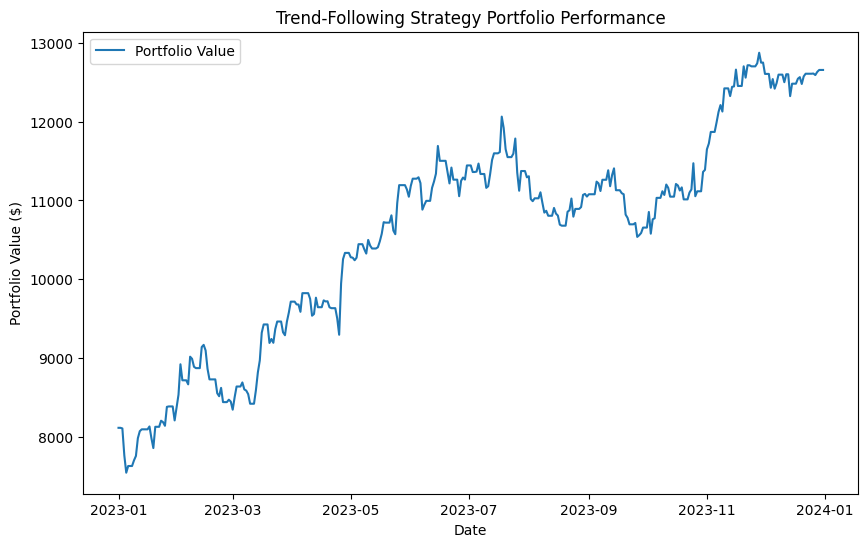

In [86]:
# Initialize stock instances
pools_1 = ["AAPL", "MSFT", "GOOGL"]
stocks = [Stock(symbol, symbol, stock_data[symbol]) for symbol in pools_1]

# Run the trend-following strategy
investment_amount = 10000
strategy_start_date = datetime.strptime("2023-01-01", "%Y-%m-%d")
strategy_end_date = datetime.strptime("2023-12-31", "%Y-%m-%d")
n_days = (strategy_end_date - strategy_start_date).days + 1

final_value = trend_follow_strategy(stocks, investment_amount, strategy_start_date, strategy_end_date)
print(f"Final Portfolio Value: ${final_value:.2f}")

# Plotting portfolio performance
portfolio_values = []
dates = [strategy_start_date+timedelta(days=i) for i in range(n_days)]
for date in dates:
    portfolio_values.append(trend_follow_strategy.portfolio.get_value_c(date))

plt.figure(figsize=(10, 6))
plt.plot(dates, portfolio_values, label="Portfolio Value")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Trend-Following Strategy Portfolio Performance")
plt.legend()
plt.show()

In [87]:
pd.DataFrame(trend_follow_strategy.portfolio.trade_history)

,0,1,2,3,4
0,buy,MSFT,30.0,2023-01-03,236.183533
1,buy,GOOGL,8.0,2023-01-03,88.899872
2,buy,GOOGL,25.0,2023-01-04,87.862442
3,sell,MSFT,30.0,2023-01-04,225.852112
4,sell,GOOGL,33.0,2023-01-05,85.987076
...,...,...,...,...,...
211,buy,MSFT,3.0,2023-12-22,372.543915
212,buy,GOOGL,1.0,2023-12-22,141.140518
213,buy,MSFT,1.0,2023-12-26,372.623505
214,sell,GOOGL,38.0,2023-12-28,139.883621


为什么下面的直线是平的？

Final Portfolio Value: $9664.70


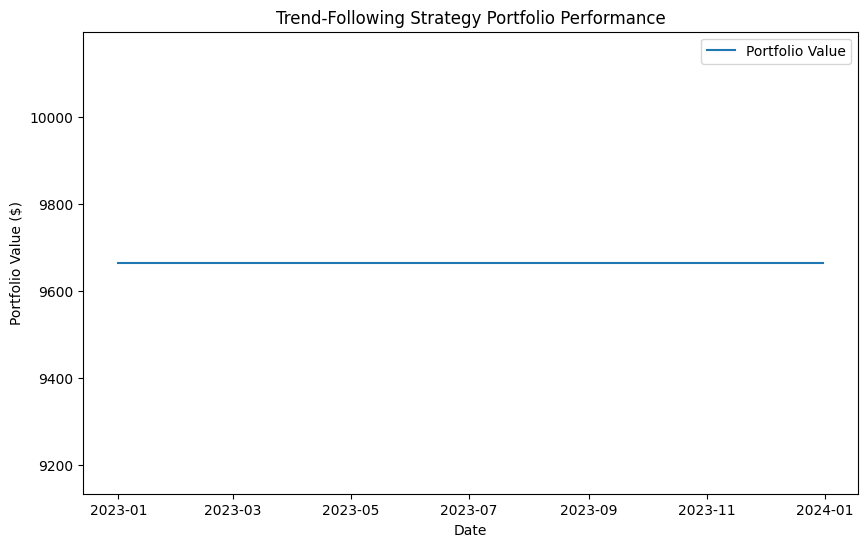

In [89]:
# Initialize stock instances
pools_2 = ["BA", "WBA"]
stocks = [Stock(symbol, symbol, stock_data[symbol]) for symbol in pools_2]

# Run the trend-following strategy
final_value = trend_follow_strategy(stocks, investment_amount, strategy_start_date, strategy_end_date, reset=True)
print(f"Final Portfolio Value: ${final_value:.2f}")

# Plotting portfolio performance
portfolio_values = []
for date in dates:
    portfolio_values.append(trend_follow_strategy.portfolio.get_value_c(date))

plt.figure(figsize=(10, 6))
plt.plot(dates, portfolio_values, label="Portfolio Value")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Trend-Following Strategy Portfolio Performance")
plt.legend()
plt.show()

In [90]:
pd.DataFrame(trend_follow_strategy.portfolio.trade_history)

,0,1,2,3,4
0,buy,BA,51.0,2023-01-03,195.389999
1,sell,BA,51.0,2023-01-18,209.410004
2,buy,BA,44.0,2023-01-23,209.970001
3,buy,WBA,6.0,2023-01-23,32.583054
4,buy,BA,6.0,2023-01-24,211.979996
...,...,...,...,...,...
110,buy,WBA,3.0,2023-12-26,25.345119
111,buy,BA,3.0,2023-12-27,262.100006
112,buy,WBA,4.0,2023-12-28,25.335598
113,sell,BA,36.0,2023-12-28,260.350006


In [92]:
trend_follow_strategy.portfolio

cash: 9664.70 |  (cost information)